# Fruit Detection
The main idea of this notebook is to find out an appropriate model for fruit recognition from the image.  
Once we can be sure about the fruit, we can measure the calorie amount the fruit could provide. Taking in consideration that the calorie amount depends on the size, quality of the fruit. Hence, the estimation would be only assumption.  

The [Moltean fruits dataset](https://www.kaggle.com/moltean/fruits) from Kaggle contains 103 class of different fruits and 53177 total images. Out idea is to perform different classification algorithms, like SVM, K-NN, Decision Tree, firstly for a binary classification, then for a multi-class classification.

PCA would be applied too in order to reduce dimensionaly of the dataset, see the distribution of the data and then try classification having only two dimension. At the end we'll make a comparison between all methods in order to find which of them perform better on this dataset.

After all, we will apply a pre-built model from [ImageAI](https://github.com/OlafenwaMoses/ImageAI).  

Once the food item is identified, we would be able to calculate the volume of food items by approximating it to a geometric shape like sphere, cylinder, etc. Once we have the volume, the mass of the food item is calculated using standard density tables. Using already available information of nutritional content of the given class of food, the total calorie content in the food image can be estimated. The work can be applied from the below reference, which needs more fine-tuned works further.

References:
- [Food calorie estimaton](https://github.com/kawitkars/Food-calorie-estimation-using-deep-learning)
- [Moltean fruit dataset](https://www.kaggle.com/moltean/fruits)
- [ImageAI](https://github.com/OlafenwaMoses/ImageAI)
- [Fruit classification](https://www.kaggle.com/waltermaffy/fruit-classification-pca-svm-knn-decision-tree)
- [Calorie estimation](https://github.com/meghanamreddy/Calorie-estimation-from-food-images-OpenCV)

For the recipe prediction, we are refering to the following interesting sources:
- [MIT team](http://pic2recipe.csail.mit.edu/)
- [Murgio - a Swiss data scientist](https://github.com/Murgio/Food-Recipe-CNN)
- [Benny Cheung](http://bennycheung.github.io/yolo-for-real-time-food-detection)
- [Inverse cooking](https://neurohive.io/en/news/inverse-cooking-deep-neural-network-generates-recipes-from-food-images/)
- [Inverse cooking GitHub](https://github.com/facebookresearch/inversecooking)  

However, we have encountered some issues with the Torch, Lua environment preparation for the pretrained model.  
The main idea of the recipe generation model is:
- Extracting image features with the image encoder,
- Encoding and embedding the recipes into ingredients,
- Generating the cooking steps by attending image embeddeing, ingredients ebmbedding and previous predicted words into together.

![Ingredient prediction example](./ingredientpredictionexample.png)

After predicting the ingredients, the cooking steps will be formed up and introducing the recipe. The belows are the case studies from the Researcher from Universitat Politecnica de Catalunya and Facebook AI Research (FAIR), whhich shows similar result as from MIT Researchers.

![Recipe prediction casestudy](./recipepredictioncasestudy.png)

This is our target!

## Data exploration

In [1]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
import pandas as pd

print(os.listdir("../input/fruits-360"))
dim = 100

['train', 'test']


In [20]:
def getFruits(fruits, data_type):
    images = []
    labels = []
    path = "../input/fruits-360/" + data_type + "/"
    
    for i,f in enumerate(fruits):
        p = path + f
        for image_path in glob.glob(os.path.join(p, "*.jpg")):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (dim, dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            images.append(image)
            labels.append(i)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("../input/fruits-360/train/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits

Here we choose some classes for analyzing purpose, 'Banana' and 'Avocado'.

In [3]:
#Choose your Fruits
fruits = ['Banana' , 'Avocado'] #Binary classification

#Get Images and Labels
X, y =  getFruits(fruits, 'train')
X_test, y_test = getFruits(fruits, 'test')

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X])
X_test = scaler.fit_transform([i.flatten() for i in X_test])

Each image is converted in a 100x100 numpy array for each RGB dimension (x3).  
Then has been scaled and flatted in one single dimension (100x100x3) in order to perform classification algorithms.

Let's visualize.

Banana


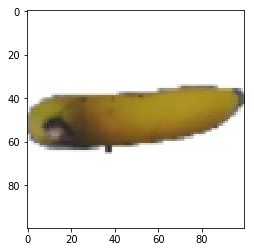

In [4]:
sample = 3
plt.imshow(X[sample])
print(fruits[y[sample]])

## Principal Component Analysis (PCA)

Let's plot the Banana and Avocado data in 2D and 3D.  
By doing so, we will need to get the class number, then plot the data distribution.  
In order to discover how our data appears we need to reduce dimensionality of the dataset in 2 or 3 dimension so that we can plot and visualize them.  
For this purpose, we use Principal Component Analysis.

In [5]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotDataDistribution(X, dim):
    v = getClassNumber(y)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

Plot of Banana data distribution in 2D

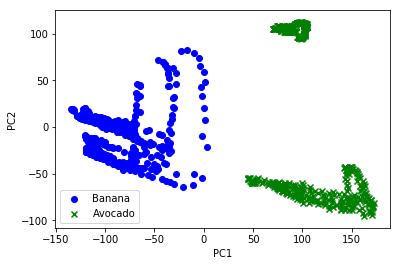

In [6]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train)
plotDataDistribution(dataIn2D, 2)

How about 3D?

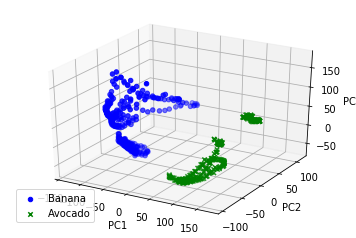

In [7]:
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train)
plotDataDistribution(dataIn3D, 3)

Now, we will see PCA how working

In [8]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure(figsize=(30,10))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('PCA 50')
    plt.imshow(X50)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('PCA 10')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('PCA 2')
    plt.imshow(X2)
    plt.show()

def computePCA(n, im_scaled, image_id):
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled)
    im_reduced = pca.inverse_transform(principalComponents)
    newImage = scaler.inverse_transform(im_reduced[image_id])
    return newImage

Example of PCA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


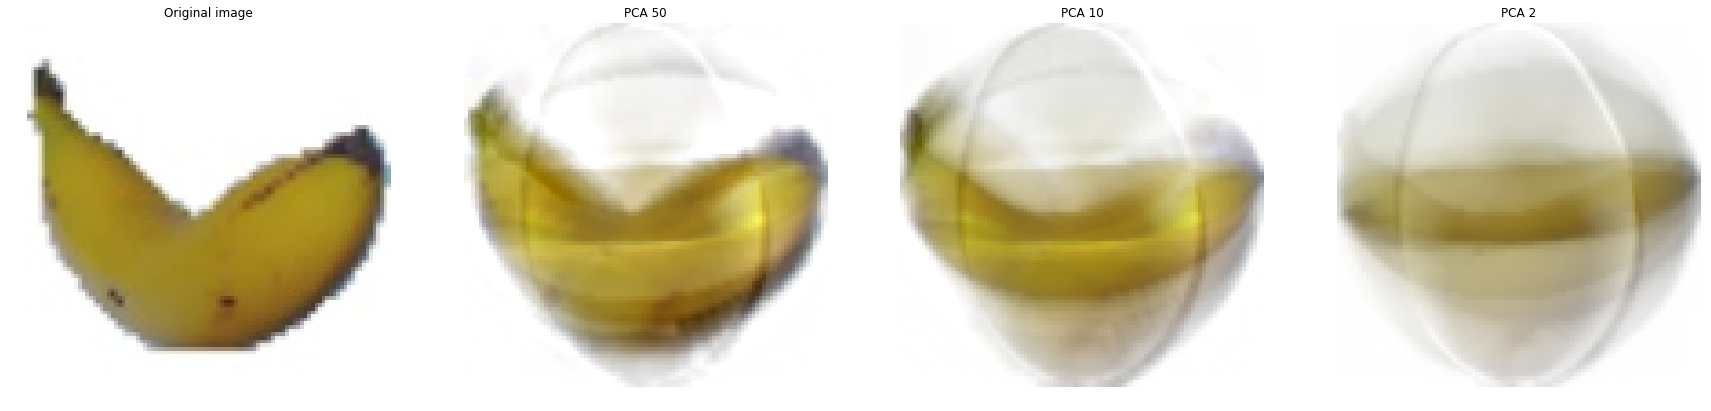

In [9]:
image_id = 5
image = X[image_id]

#Compute PCA
X_2 = computePCA(2, X_train,image_id)
X_10 = computePCA(10, X_train,image_id)
X_50 = computePCA(50, X_train,image_id)

#Reshape in order to plot images
X2 = np.reshape(X_2, (dim,dim,3)).astype(int)
X10 = np.reshape(X_10, (dim,dim,3)).astype(int)
X50 = np.reshape(X_50, (dim,dim,3)).astype(int)

#Plot
showPCA(image, X2, X10, X50)

## Binary distributions

### Support Vector Machines

If a dataset is linearly separable it means that we could use a hard margin approach, or rather find the two parallel hyperplanes that separate the two classes of data, so that the distance between them is as large as possible and so we are being able to identify to which class belongs each point of the dataset.  
But mostly of the time datasets are not linearly separable and so we can take two ways, one is to continue using a Linear approach using Soft Margin, or simplifying, admitting some misclassification.  
While the second way is to use a Non-Linear Kernel (that must satisfy Mercer Condition) or rather a mapping of the data on a higher dimensional space, where the data is linearly separable and the classification task can be solved easly,without even need to calculate the points projections.

Accuracy with SVM: 100.00%


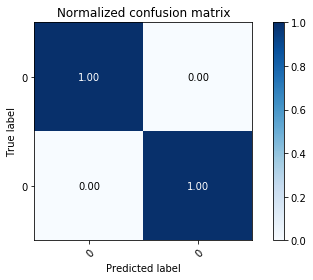

In [10]:
#SVM 
svm = SVC(gamma='auto', kernel='linear', probability=True)
svm.fit(X_train, y) 
y_pred = svm.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_pred, y_test, classes=y, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = svm.predict_proba(X_test)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, probs)
svm_auc = metrics.roc_auc_score(y_test, probs)

Accuracy with SVM considering only first 2PC: 100.00%


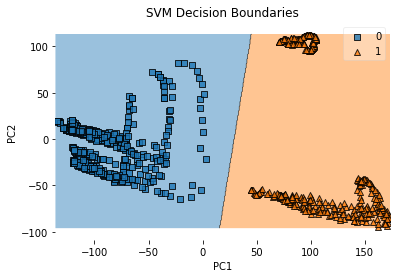

In [11]:
#SVM + PCA
pca = PCA(n_components=2)
X_train2D = pca.fit_transform(X_train)
X_test2D = pca.fit_transform(X_test)

svm.fit(X_train2D, y) 
test_predictions = svm.predict(X_test2D)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM considering only first 2PC: {0:.2f}%".format(precision))

#Plotting decision boundaries
plot_decision_regions(X_train2D, y, clf=svm, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('SVM Decision Boundaries')
plt.show()

In [12]:
#KERNEL SVM + PCA 
svm_with_kernel = SVC(gamma='auto', kernel='rbf', probability=True)
svm_with_kernel.fit(X_train2D, y) 
y_pred = svm_with_kernel.predict(X_test2D)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Not-Linear SVM considering only first 2PC: {0:.2f}%".format(precision))

Accuracy with Not-Linear SVM considering only first 2PC: 53.72%


### K-NN

K-NN is a supervised learning method that considers the K closest training examples to the point of interest for predicting its class.  
The point is assigned to the class that is closest.

Accuracy with K-NN: 100.00%


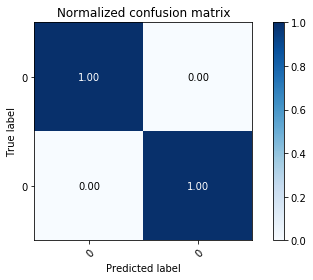

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y)
y_pred = knn.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_test)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, probs)
knn_auc = metrics.roc_auc_score(y_test, probs)

Accuracy with K-NN considering only first 2PC: 100.00%


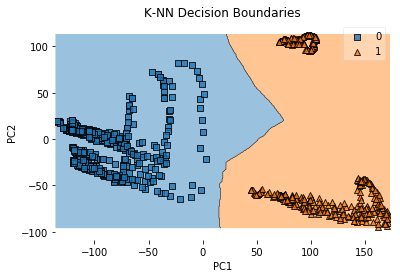

In [14]:
#K-NN + PCA
knn.fit(X_train2D, y)
y_pred = knn.predict(X_test2D)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN considering only first 2PC: {0:.2f}%".format(precision))

#Plotting decision boundaries
plot_decision_regions(X_train2D, y, clf=knn, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-NN Decision Boundaries')
plt.show()

### DECISION TREE

In a decision tree each intermediate node of the tree contains splitting attributes used to build different paths, while leaves contains class labels.  
There are differt algorithm to build a decision tree, but all are made with a greedy approach, optimal locally, because number of partitions has a factorial growth.
The most famous is Hunt's algoritm. 

Accuracy with Decision Tree: 97.73%


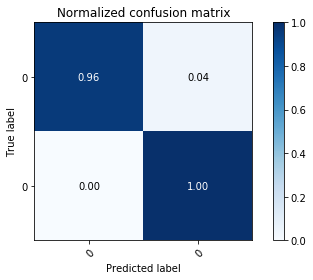

In [15]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y)
y_pred = tree.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = tree.predict_proba(X_test)
probs = probs[:, 1]
tree_fpr, tree_tpr, thresholds = metrics.roc_curve(y_test, probs)
tree_auc = metrics.roc_auc_score(y_test, probs)

Accuracy with Decision Tree considering only first 2PC: 100.00%


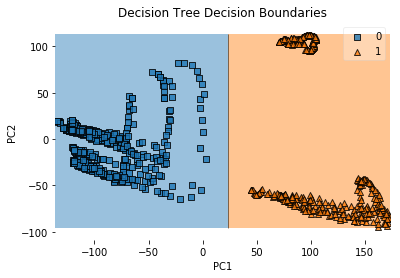

In [16]:
#DECISION TREE + PCA
tree = tree.fit(X_train2D,y)
y_pred = tree.predict(X_test2D)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree considering only first 2PC: {0:.2f}%".format(precision))

#Plotting decision boundaries
plot_decision_regions(X_train2D, y, clf=tree, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Decision Tree Decision Boundaries')
plt.show()

## Model evalution

In order to find the most suitable algorithm to this dataset, different evaluation methods will be presented: Accuracy, Confusion Matrix, ROC Curve.
- TP = #samples for which the prediction is Fruit1 and the true label is Fruit1
- FP = #samples for which the prediction is Fruit2 but the true label is Fruit1
- TN = #samples for which the prediction is Fruit2 and the true label is Fruit2
- FN = #samples for which the prediction is Fruit1 but the true label is Fruit2

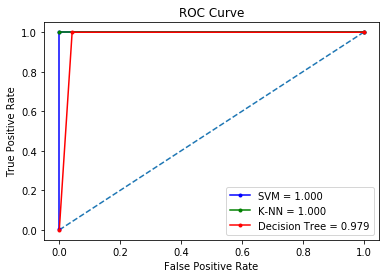

In [17]:
#ROC CURVE
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM = %0.3f' % svm_auc )
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'K-NN = %0.3f' % knn_auc)
plt.plot(tree_fpr, tree_tpr, 'r', marker='.',label = 'Decision Tree = %.3f' % tree_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Multi-class classification

Similarly, we will try to classify multiple classes from the dataset with SVM, K-NN, and Decision Tree.

In [21]:
fruits = ['Orange', 'Banana' , 'Strawberry', 'Apple Golden 1', 'Kiwi' , 'Lemon', 'Avocado' , 'Pineapple' , 'Peach', 'Cherry 1', 'Cherry 2', 'Mandarine']
#The following call is for all fruits which will need a lot of memory and performance might degrade
#fruits = getAllFruits()

#Get Images and Labels
X, y =  getFruits(fruits, 'train')
X_test, y_test = getFruits(fruits, 'test')

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X])
X_test = scaler.fit_transform([i.flatten() for i in X_test])

In [22]:
#SVM
model = SVC(gamma='auto', kernel='linear')
model.fit(X_train, y) 
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))

#K-NN
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y)
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))

#DECISION TREE
model = DecisionTreeClassifier()
model.fit(X_train,y)
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))

Accuracy with SVM: 99.90%
Accuracy with K-NN: 97.83%
Accuracy with Decision Tree: 82.85%


# ImageAI pre-built model application

Here we will use the pre-built model from the ImageAI to predict the fruit from the image.  The result of the prediction is the generated image with boundary of the predicted class and its probability percentage.  

Base on this approach, we will apply similarly in our application by providing an API, so the client can upload the captured image, then server will process and return to the client the predicted image and probability results.  

One note here, the ImageAI model will read the data for training from 'train' folder and for testing from 'test' folder.  

The data for testing purpose is extracted from the Moltean dataset with smaller set (with 2 classes like Banana and Apple) to test the pre-built model or even to produce our model based on the [API](https://imageai.readthedocs.io/en/latest/).

In [23]:
from imageai.Detection import ObjectDetection
import os

execution_path = os.getcwd()

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath( os.path.join(execution_path , "./resnet50_coco_best_v2.0.1.h5"))
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image=os.path.join(execution_path , "/notebook/fruit-detection/val/2.jpg"), output_image_path=os.path.join(execution_path , "./imagenew.jpg"))

for eachObject in detections:
    print(eachObject["name"] , " : " , eachObject["percentage_probability"] )

Using TensorFlow backend.


apple  :  60.86652874946594


In [31]:
from imageai.Prediction.Custom import ModelTraining
model_trainer = ModelTraining()
model_trainer.setModelTypeAsResNet()
model_trainer.setDataDirectory("../input/2")
model_trainer.trainModel(num_objects=2, num_experiments=1, enhance_data=True, batch_size=20, show_network_summary=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_371 (Conv2D)             (None, 112, 112, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_371 (Bat (None, 112, 112, 64) 256         conv2d_371[0][0]                 
__________________________________________________________________________________________________
activation_350 (Activation)     (None, 112, 112, 64) 0           batch_normalization_v1_371[0][0] 
__________________________________________________________________________________________________
max_poolin

In [35]:
from imageai.Prediction.Custom import CustomImagePrediction
prediction = CustomImagePrediction()
prediction.setModelTypeAsResNet()
prediction.setModelPath("/notebook/input/2/models/model_ex-001_acc-0.496970.h5")
prediction.setJsonPath("/notebook/input/2/json/model_class.json")
prediction.loadModel(num_objects=2)
predictions, probabilities = prediction.predictImage("/notebook/input/2/test/Apple/321_100.jpg", result_count=2)
for eachPrediction, eachProbability in zip(predictions, probabilities):
     print(eachPrediction , " : " , eachProbability)

Apple  :  100.0
Banana  :  5.7428821218080956e-24
